## Практическое задание  № 3. Dataset, Dataloader, BatchNorm, Dropout, Оптимизация

Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:

- Создать Dataset для загрузки данных
- Обернуть его в Dataloader
- Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
- Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [1]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [2]:
import torch

In [3]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [4]:
cal_housing_dataset = fetch_california_housing()
cal_housing = pd.DataFrame(cal_housing_dataset.data, columns=cal_housing_dataset.feature_names)
cal_housing['MedValue'] = cal_housing_dataset.target
cal_housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [5]:
print(cal_housing_dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [6]:
cal_housing.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedValue,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


C:\prj\GeekBrainsAI\gb_pytorch\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


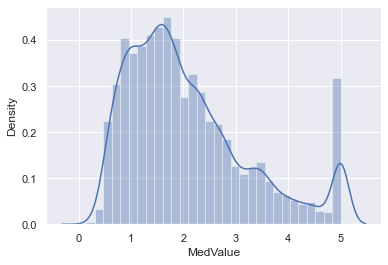

In [7]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.distplot(cal_housing.MedValue, bins=30)
plt.show()

In [8]:

X_train, X_test, y_train, y_test = train_test_split(cal_housing.drop(columns='MedValue'), cal_housing.MedValue, test_size=0.25, random_state=13)

In [15]:
class HouseCalifornia(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self._X = X
        self._y = y

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        return self._X.iloc[idx].to_numpy(), self._y.iloc[idx]



In [16]:
X_train.iloc[0].to_numpy()

array([ 3.51740000e+00,  3.60000000e+01,  4.54794521e+00,  1.09436834e+00,
        1.35700000e+03,  2.06544901e+00,  3.42100000e+01, -1.18230000e+02])

In [17]:
dataset = HouseCalifornia(X_train, y_train);

In [18]:
dataset[0]

(array([ 3.51740000e+00,  3.60000000e+01,  4.54794521e+00,  1.09436834e+00,
         1.35700000e+03,  2.06544901e+00,  3.42100000e+01, -1.18230000e+02]),
 2.68)

In [19]:
len(dataset)

15480

In [20]:
dataset[len(dataset)-1]

(array([ 2.24670000e+00,  4.60000000e+01,  5.94067797e+00,  1.10451977e+00,
         1.33900000e+03,  3.78248588e+00,  3.77400000e+01, -1.22180000e+02]),
 0.889)

In [21]:
a=np.array([1, 2, 3])
len(a)

3

In [22]:
train_loader = torch.utils.data.DataLoader(dataset,
                          batch_size=1,
                          shuffle=False,
                          num_workers=1)

In [23]:
len(train_loader)

15480

In [ ]:
for batch, label in enumerate(train_loader):
    print(batch)
    break

In [ ]:
l=iter(train_loader)


In [15]:
l.next()

AttributeError: 'iterator' object has no attribute 'next'

In [19]:
X_train.iloc[0]

MedInc           3.517400
HouseAge        36.000000
AveRooms         4.547945
AveBedrms        1.094368
Population    1357.000000
AveOccup         2.065449
Latitude        34.210000
Longitude     -118.230000
Name: 5707, dtype: float64

In [12]:
dataset.__len__()

15480

In [14]:
dataset.__getitem__(1)

(MedInc           2.972800
 HouseAge        36.000000
 AveRooms         4.299465
 AveBedrms        0.997326
 Population    1217.000000
 AveOccup         3.254011
 Latitude        34.180000
 Longitude     -118.370000
 Name: 3754, dtype: float64,
 1.902)